In [1]:
import pandas as pd
import numpy as np

# Import data and drop supply target feature
demand_df = pd.read_excel("AA.Sakakah 2021 Demand dataset.xlsx")
df = pd.read_csv("../Clean Data.csv")
df = df.drop(columns=["Mega Watts"])

# Ensure both timestamp columns are in datetime format
df["DATE & TIME"] = pd.to_datetime(df["DATE & TIME"])
demand_df["DATE-TIME"] = pd.to_datetime(demand_df["DATE-TIME"])

# Merge the datasets
df = pd.merge(df, demand_df, left_on = "DATE & TIME", right_on = "DATE-TIME", how = "inner")

# Drop 'DATE-TIME' column
df.drop(columns = ["DATE-TIME"], inplace = True)

# Rename target column:
df.rename(columns = {"MW": "MW Demand"}, inplace=True)

print(df.isnull().sum())  # Check for NaNs


DATE & TIME                 0
Solar Radiation (Wh/m)2     0
UV Intensity                0
Atmospheric Clarity         0
Temperature (2m)            0
Humidity (2M)               0
PS                          0
Wind Speed (10m)            0
Wind Direction (10m)        0
MW Demand                  13
dtype: int64


I can see that 13 of the demand target column has missing values <br>
this explains the previous issues when training as it would display nan for loss and mae score <br>
## Fixing missing values

In [2]:
# Print rows where the target feature has NaN values
missing_values_rows = df[df["MW Demand"].isnull()]
missing_values_rows.head(len(missing_values_rows))

,DATE & TIME,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Demand
1689,2021-03-12 09:00:00,525.55,3.10,0.650000,14.94,5.86,93.14,16.08,288.27,NaN
1690,2021-03-12 10:00:00,625.25,5.10,0.620000,15.81,4.58,93.19,15.86,290.23,NaN
1691,2021-03-12 11:00:00,727.46,6.33,0.650000,17.10,3.97,93.17,14.27,289.25,NaN
1692,2021-03-12 12:00:00,738.36,5.55,0.640000,18.30,3.85,93.11,12.92,288.43,NaN
1720,2021-03-13 16:00:00,295.09,0.77,0.530000,19.20,2.50,93.74,1.14,83.31,NaN
1721,2021-03-13 17:00:00,97.48,0.08,0.370000,17.05,3.85,93.77,1.39,79.95,NaN
1722,2021-03-13 18:00:00,5.63,0.00,0.290000,13.52,3.48,93.79,2.42,84.81,NaN
1723,2021-03-13 19:00:00,0.00,0.00,0.296667,11.69,3.23,93.81,3.11,89.42,NaN
1724,2021-03-13 20:00:00,0.00,0.00,0.303333,10.55,3.05,93.83,3.43,95.23,NaN
2744,2021-04-25 08:00:00,479.96,2.38,0.620000,26.01,4.27,93.34,1.31,134.52,NaN


In [3]:
# Linear Interpolation to fix NaN values
df["MW Demand"] = df["MW Demand"].interpolate(method = 'linear')

# Check if the NaN values have been replaced
print(df.isnull().sum())

DATE & TIME                0
Solar Radiation (Wh/m)2    0
UV Intensity               0
Atmospheric Clarity        0
Temperature (2m)           0
Humidity (2M)              0
PS                         0
Wind Speed (10m)           0
Wind Direction (10m)       0
MW Demand                  0
dtype: int64


In [4]:
# Convert Date & Time into seconds as a timestamp
df["timestamp"] = df["DATE & TIME"].astype("int64") // 10**9 # Convert time into seconds
df.drop(columns = ["DATE & TIME"], inplace = True)

## Normalizing Data

In [5]:
from sklearn.preprocessing import MinMaxScaler

x = df.drop(columns=["MW Demand"])
y = df["MW Demand"].values.reshape(-1, 1)

# Split 80% train+val and 20% test
train_size = int(0.8 * len(x))
val_size = int(0.1 * train_size)  # 10% of train+val as val

x_train_full, x_test = x[:train_size], x[train_size:]
y_train_full, y_test = y[:train_size], y[train_size:]

# Split train+val into train and val
x_train, x_val = x_train_full[:-val_size], x_train_full[-val_size:]
y_train, y_val = y_train_full[:-val_size], y_train_full[-val_size:]

# Scale using training data only
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

## Creating Sequence
Sequences are used to create sections of data <br>
Each sequence is a window of time, the size of this window is defined by a look back variable (in this case 24 hours)

In [58]:
def create_sequence(data, labels, look_back):
    sequences = []
    label_values = []

    # Convert Data to Numpy array
    data = data.values if isinstance(data, pd.DataFrame) else data
    labels = labels.values if isinstance(labels, pd.Series) else labels

    for i in range(len(data) - look_back):
        '''
        1. This looks at the first 24 values and then gives it the label 25
        2. Then starts at the second hour in the feature and then looks at the next 24 values and increments the label (in this case next label is 26)
        3. Putting it simple, each sequences loses the first hour (making the previous second hour the first) and then adds the hour after the
           previous sequence to be the last hour in the new sequence
        4. This repeats through the whole given dataset
        This splits the whole data set into 24 hour chunks going up by 1 hour for each sequence
        EXAMPLE:
           Context:
                - Hour 6 target Value = 4.3 MW
                - Hour 7 target Value = 5.2 MW
                - Number in [] are data from each feature (Simplified to normal numbers)
           look_back = 5
           SEQ.1 = [1, 2, 3, 4, 5] // Label = 4.3 MW (Next hour is 6 so label is hour 6 target value)
           SEQ.2 = [2 ,3, 4, 5, 6] // Label = 5.2 MW (Next hour is 7 so label is hour 7 target value)
        '''
        seq = data[i: i + look_back]  # Collect data for the look-back (past 24 hours of data)
        label = labels[i + look_back]  # Creates label by incrementally by 1 after each set of 24 hour

        sequences.append(seq)
        label_values.append(label)

    return (np.array(sequences),
            np.array(label_values).reshape(-1, 1))

look_back = 24  # look back at the past 24 hours

# Create sequences and labels for sets of 24 hour look backs for each dataset
'''
X vars are multiple dimension arrays (Holds the input features for each sequence)
Y vars are a single dimension array (Each label is the target value for each sequence)
First Sequence  (label = target value for hour 1)
Second Sequence (label = target value for hour 2)
etc...
'''
X_train_seq, y_train_seq = create_sequence(x_train_scaled, y_train_scaled, look_back)
X_val_seq, y_val_seq = create_sequence(x_val_scaled, y_val_scaled, look_back)
X_test_seq, y_test_seq = create_sequence(x_test_scaled, y_test_scaled, look_back)

# Output shapes of the datasets
print(f"Training    X sequences shape:  {X_train_seq.shape}\n"
      f"Training    Y sequences shape:  {y_train_seq.shape}\n"
      f"Validation  X sequences shape:  {X_val_seq.shape}\n"
      f"Validation  Y sequences shape:  {y_val_seq.shape}\n"
      f"Testing     X sequences shape:  {X_test_seq.shape}\n"
      f"Testing     Y sequences shape:  {y_test_seq.shape}")

# Check Y vars for correct data (Just going to check training data)
y_train_df = pd.DataFrame(y_train_seq)
y_train_df.head(100)

Training    X sequences shape:  (6284, 24, 9)
Training    Y sequences shape:  (6284, 1)
Validation  X sequences shape:  (676, 24, 9)
Validation  Y sequences shape:  (676, 1)
Testing     X sequences shape:  (1728, 24, 9)
Testing     Y sequences shape:  (1728, 1)


,0
0,0.302599
1,0.258950
2,0.216037
3,0.181707
4,0.170181
...,...
95,0.264590
96,0.225601
97,0.191761
98,0.167974


Dataset Sequence Shape:
- Value 1 --> Number of rows in the dataset
- Value 2 --> Value for the look back (24 hours)
- Value 3 --> Number of features:
    - ( X vars --> 9 features (minus target feature "Mega Watts"))
    - ( Y vars --> 1 feature (minus input features but only target feature)

# Create Long-Short Term Memory (LSTM) Neural Network

In [75]:
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create the layers
model = Sequential()
model.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train_seq.shape[1], X_train_seq.shape[2]), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(LSTM(units = 16, return_sequences = False, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1))

# .shape[1] --> look back (24 hours)
# .shape[2] --> number of features (9 features)

# Compile the model
model.compile(
    optimizer = Adam(learning_rate=5e-5),
    loss = "huber",
    metrics = ["mae"],
)

## Train The Model

In [77]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Learning Rate Scheduler --> Make sures the learning rate starts off high but then slows down when epochs see small important
LR_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True)

history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs = 50,
    validation_data = (X_val_seq, y_val_seq),
    callbacks = [early_stopping, LR_scheduler],
    verbose = 1
)

Epoch 1/50
197/197 [==============================] - 4s 20ms/step - loss: 0.0709 - mae: 0.1381 - val_loss: 0.0924 - val_mae: 0.2599 - lr: 5.0000e-05
Epoch 2/50
197/197 [==============================] - 4s 18ms/step - loss: 0.0664 - mae: 0.1322 - val_loss: 0.1036 - val_mae: 0.3097 - lr: 5.0000e-05
Epoch 3/50
197/197 [==============================] - 4s 21ms/step - loss: 0.0623 - mae: 0.1278 - val_loss: 0.0990 - val_mae: 0.3048 - lr: 5.0000e-05
Epoch 4/50
197/197 [==============================] - 4s 22ms/step - loss: 0.0579 - mae: 0.1213 - val_loss: 0.0987 - val_mae: 0.3131 - lr: 5.0000e-05
Epoch 5/50
197/197 [==============================] - 3s 17ms/step - loss: 0.0556 - mae: 0.1201 - val_loss: 0.0982 - val_mae: 0.3161 - lr: 2.5000e-05
Epoch 6/50
197/197 [==============================] - 3s 17ms/step - loss: 0.0538 - mae: 0.1193 - val_loss: 0.0973 - val_mae: 0.3179 - lr: 2.5000e-05
Epoch 7/50
197/197 [==============================] - 4s 18ms/step - loss: 0.0517 - mae: 0.1168 - va

# Evaluate The Model



In [78]:
from sklearn.metrics import mean_absolute_error

# Predict on train, test, val sequences
y_train_pred_scaled = model.predict(X_train_seq)
y_test_pred_scaled = model.predict(X_test_seq)
y_val_pred_scaled = model.predict(X_val_seq)

# Inverse scale predictions and true values
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

y_train_true = y_scaler.inverse_transform(y_train_seq)
y_test_true = y_scaler.inverse_transform(y_test_seq)
y_val_true = y_scaler.inverse_transform(y_val_seq)

# Calculate MAE for each dataset
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)

# Calculate mean of true values (for relative error)
mean_train = np.mean(y_train_true)
mean_test = np.mean(y_test_true)
mean_val = np.mean(y_val_true)

# Calculate RMAE
rmae_train = mae_train / mean_train
rmae_test = mae_test / mean_test
rmae_val = mae_val / mean_val

print(f"Training RMAE: {rmae_train * 100:.2f}%")
print(f"Validation RMAE: {rmae_val * 100:.2f}%")
print(f"Testing RMAE: {rmae_test * 100:.2f}%")

22/22 [==============================] - 0s 4ms/step
Training RMAE: 8.25%
Validation RMAE: 35.03%
Testing RMAE: 65.76%


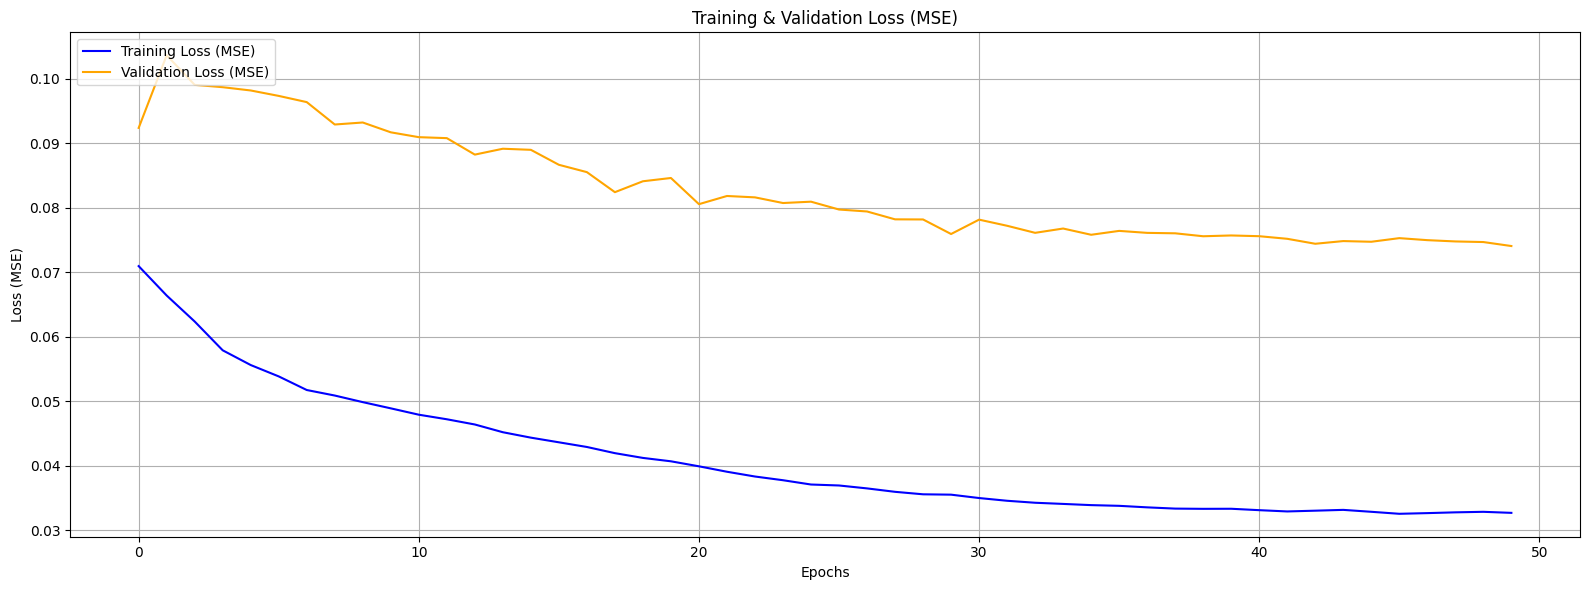

In [79]:
import matplotlib.pyplot as plt

training_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_rmse = np.sqrt(training_loss)  # RMSE is the square root of the loss (MSE)
val_rmse = np.sqrt(val_loss)  # RMSE for validation

# Plot for Loss
plt.figure(figsize=(16, 6))
plt.plot(training_loss, label="Training Loss (MSE)", color="blue")
plt.plot(val_loss, label="Validation Loss (MSE)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss (MSE)")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


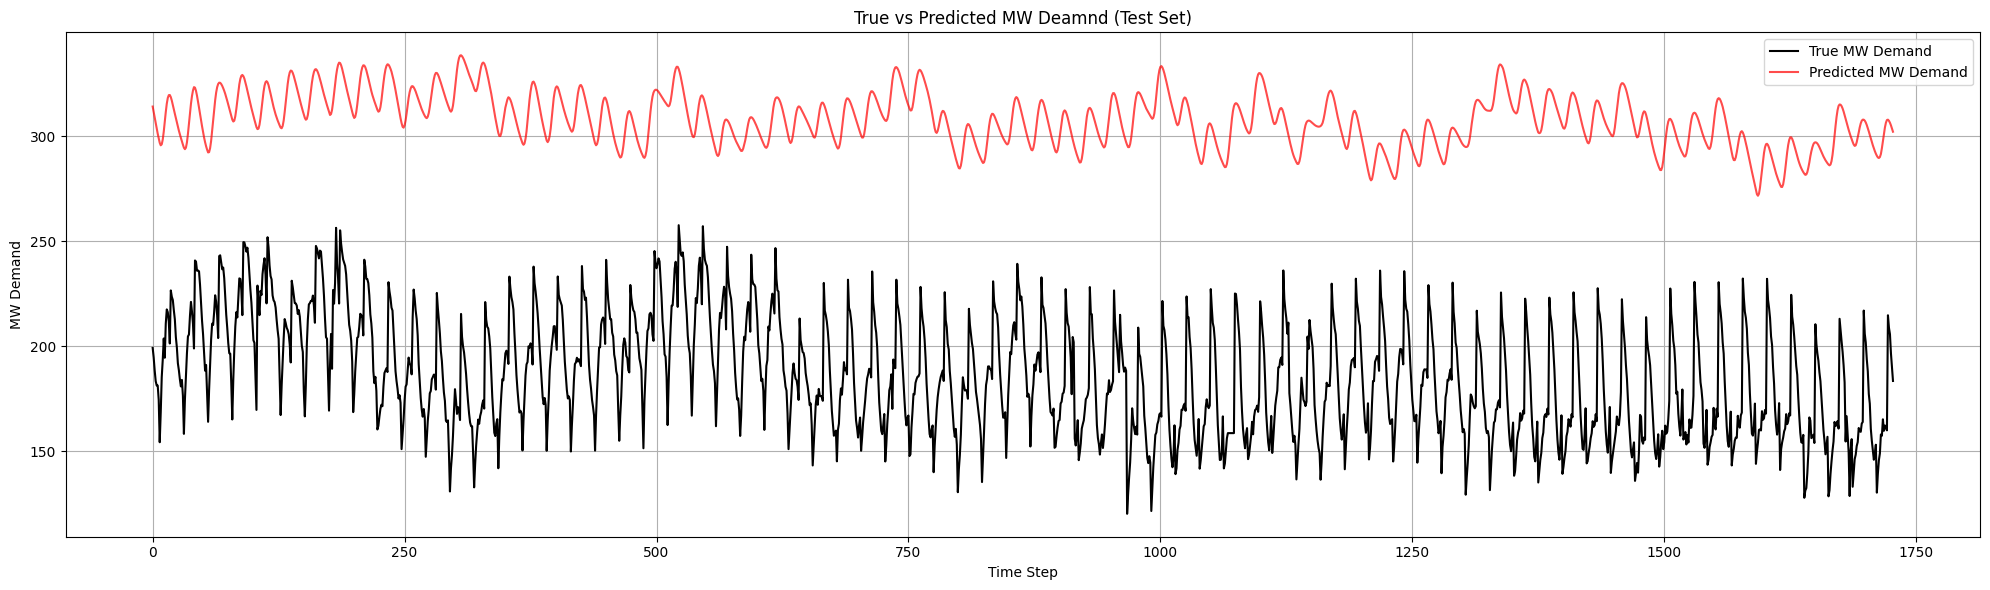

In [80]:
# Plot True vs Predicted for Test Set
plt.figure(figsize=(20, 6))
plt.plot(y_test_true, label="True MW Demand", color="black")
plt.plot(y_test_pred, label="Predicted MW Demand", color="red", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("MW Demand")
plt.title("True vs Predicted MW Deamnd (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
